In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('titanic/train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Распределение людей по полу

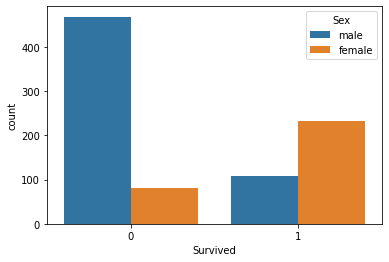

In [3]:
sns.countplot(x = 'Survived', hue = 'Sex', data = df);

### Распределение людей по возрасту

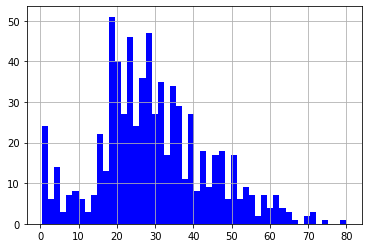

In [4]:
df['Age'].hist(bins = 50, color = 'blue');

# Подготовка данных для обучения

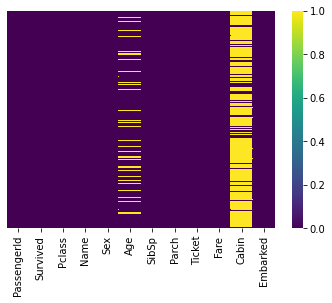

In [5]:
# Распределение пропусков ПО КОЛОНКАМ
sns.heatmap(df.isnull(), xticklabels=True, yticklabels=False, cmap='viridis');

In [6]:
X = df.drop(['PassengerId', 'Survived','Name','Ticket','Cabin'], axis = 'columns')
y = df[['Survived']]

### Замена строковых данных на числовые и удаление пропусков

In [7]:
X = pd.get_dummies(X).drop('Sex_female', axis = 'columns')
X.fillna({'Age': X.Age.median()}, inplace=True)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,0,0,1
1,1,38.0,1,0,71.2833,0,1,0,0
2,3,26.0,0,0,7.9250,0,0,0,1
3,1,35.0,1,0,53.1000,0,0,0,1
4,3,35.0,0,0,8.0500,1,0,0,1


## Разбиваем данные для обучения и тестирования

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Обучение дерева решений

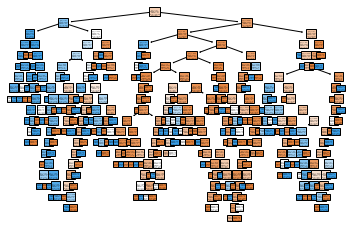

In [9]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy')
tree.plot_tree(clf.fit(X, y) ,class_names=['Died', 'Survived'], filled=True);

# Тестирование показало что дерево переобучено
#### * обучим дерево на `X_train`, `y_train`

In [10]:
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.9798657718120806

#### * тест обучающей модели на `X_test`, `y_test` (данные которые она не видела)

In [11]:
clf.score(X_test, y_test)

0.7796610169491526

# Избавляемся от переобучения дерева

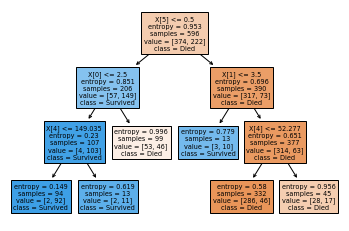

In [36]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=100, min_samples_leaf=10)
tree.plot_tree(clf.fit(X_train, y_train) ,class_names=['Died', 'Survived'], filled=True);

In [34]:
clf.score(X_train, y_train)

0.8204697986577181

###  Классификатор стал работать лучше на данных которые он не видел

In [35]:
clf.score(X_test, y_test)

0.8169491525423729

## Подбор `max_depth` для лучшего результата

In [15]:
max_depth_values = range(1, 80)
scoresDF =pd.DataFrame()

for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    test_score_data = pd.DataFrame({'max_depth':[max_depth],
                                    'train_score':[train_score],
                                    'test_score':[test_score],
                                    'cross_val_score':[mean_cross_val_score],
                                   })
    scoresDF = scoresDF.append(test_score_data)

In [16]:
scoresDFlong = pd.melt(scoresDF, id_vars=['max_depth'],
                       value_vars=['train_score','test_score', 'cross_val_score'],
                       var_name='set_type',
                       value_name='score')
scoresDFlong

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604
...,...,...,...
232,75,cross_val_score,0.773543
233,76,cross_val_score,0.770182
234,77,cross_val_score,0.763459
235,78,cross_val_score,0.775224


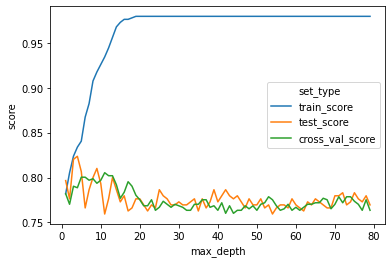

In [17]:
sns.lineplot(x='max_depth',y='score',hue='set_type',data=scoresDFlong);

In [18]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)
best_clf.fit(X_train, y_train)
best_clf.score(X_test, y_test)

0.7932203389830509

## Подбор наилучших параметров дерева (`criterion, max_depth`)

In [19]:
clf = tree.DecisionTreeClassifier()

In [20]:
from sklearn.model_selection import GridSearchCV
parametrs = {'criterion':['gini', 'entropy'], 'max_depth': range(1,30)}
grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5)

In [21]:
# наилучшие параметры
grid_search_cv_clf.fit(X_train, y_train)
grid_search_cv_clf.best_params_, grid_search_cv_clf.best_score_

({'criterion': 'entropy', 'max_depth': 6}, 0.8054341736694678)

In [22]:
# наилучший классификатор
best_clf = grid_search_cv_clf.best_estimator_

<p><b>precision</b> более важен в ситуациях, где не нужны ложные положительные срабатывания<br>
<b>recall</b> - там, где не нужны ложные отрицательные</p>

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
def drow_roc(y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc= auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
              label='ROC curve (area = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### Видим что `recall` мал (много ложных срабатываний)
- построим `ROC` кривую

In [24]:
from sklearn.metrics import precision_score, recall_score
y_pred = best_clf.predict(X_test)
precision_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.8023255813953488, 0.575)

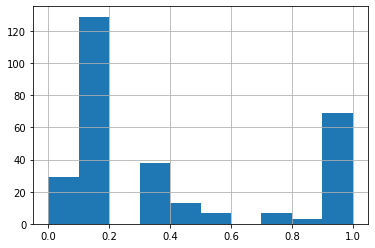

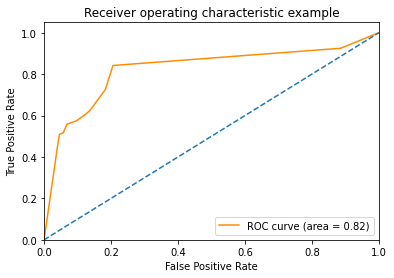

In [25]:
y_predicted_prob = best_clf.predict_proba(X_test)
pd.Series(y_predicted_prob[:, 1]).hist();
drow_roc(y_predicted_prob[:, 1]);

### Увеличиваем `precision`(точность)

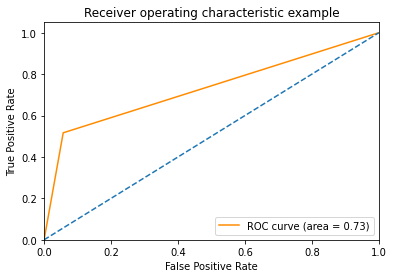

(0.8611111111111112, 0.5166666666666667)

In [26]:
y_pred1 = np.where(y_predicted_prob[:, 1]>0.8, 1, 0)
drow_roc(y_pred1);
precision_score(y_test, y_pred1), recall_score(y_test, y_pred1)

### Увеличиваем `recall`

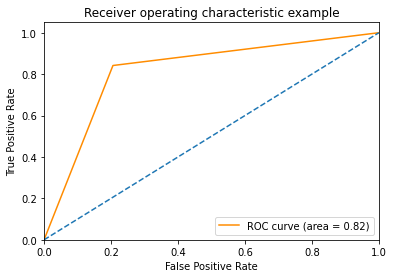

(0.7372262773722628, 0.8416666666666667)

In [27]:
y_pred2 = np.where(y_predicted_prob[:, 1]>0.2, 1, 0)
drow_roc(y_pred2)
precision_score(y_test, y_pred2), recall_score(y_test, y_pred2)